- Load the image
- convert them to tensors
-train test split 


- Define model (architecture)
-optimizers
- cross entropy loss

- Training Loop
    - forward pass
    - 

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to tensors
])

# Load the dataset from the folder
dataset_path = "data/use"  # Replace with the actual path to the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
import torch.nn as nn
import torch
from torch import optim
import torch.nn.functional as F 

In [32]:
class Model(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 3)  # Set to 3 if you have 3 potato classes
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
        

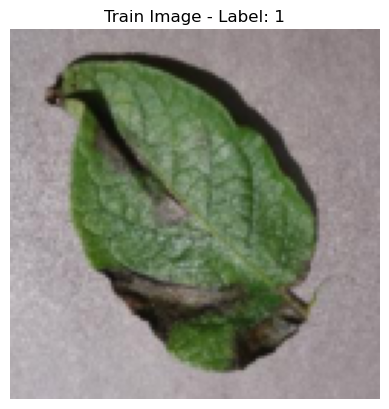

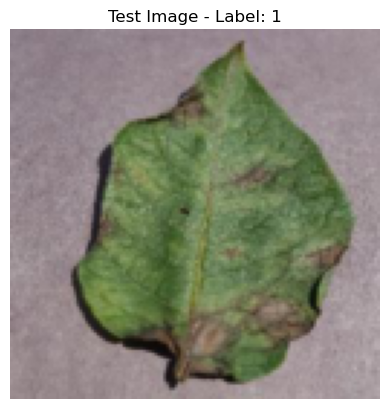

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# Function to display an image
def show_image(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display one image from the training dataset
train_img, train_label = train_dataset[0]
show_image(train_img, title=f"Train Image - Label: {train_label}")

# Display one image from the testing dataset
test_img, test_label = test_dataset[0]
show_image(test_img, title=f"Test Image - Label: {test_label}")

In [51]:
cnn = Model(in_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [55]:
# Training loop
epochs = 3  # Number of epochs
for epoch in range(epochs):
    for feature, label in train_loader:
        feature = feature.to(device)
        label = label.to(device)
        output = cnn(feature)
        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


    

Epoch 1/3, Loss: 1.0647615194320679
Epoch 2/3, Loss: 0.7433116436004639
Epoch 3/3, Loss: 0.827069103717804


In [56]:
cnn.eval()
crct = 0
with torch.no_grad():
    for feature, label in test_loader:
        feature = feature.to(device)
        label = label.to(device)
        output = cnn(feature)
        predicted = torch.max(output, dim=1).indices
        crct += (predicted == label).sum().item()
    accuracy = crct / len(test_dataset)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 69.84%


In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

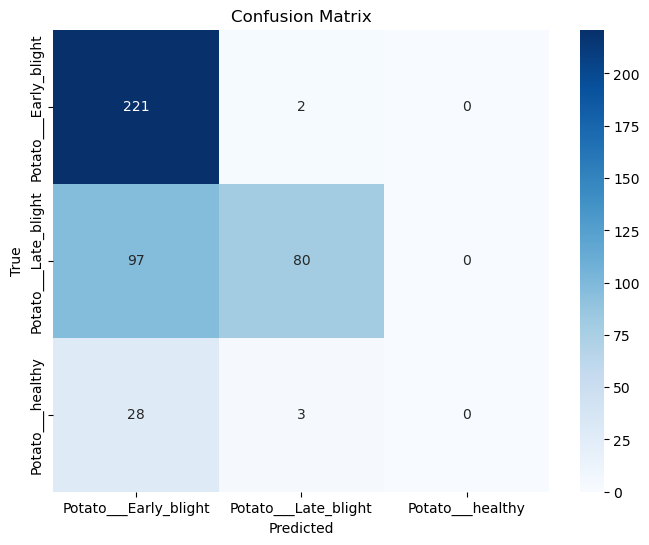

In [60]:
y_true = []
y_pred = []
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        outputs = cnn(batch_features)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()  